# Total efficiencies checks in MC

Ivan Cambon Bouzas

In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import uncertainties as un
import sys 
import os
import mplhep
import yaml

python_modules_path = "/home3/ivan.cambon/Python_Modules"
sys.path.append(f'{python_modules_path}/RooPyShort')
sys.path.append(f'{python_modules_path}/RooPyFit')
import RooPyFit as rpf
import RooPyShort as rsh

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()
mplhep.styles.use(mplhep.styles.LHCb2)

Welcome to JupyROOT 6.28/04
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
folders = ["plots", "param_files", "root_files"]

for f in folders:
    if not os.path.exists(f"./{f}"):
        os.makedirs(f"./{f}")

pol  = "MagDown"
year = "2018"
run2 = False

### Data reading

In [3]:
head_path = "/scratch42/ivan.cambon/DsJ_Spectroscopy/Reduced"

mc_raw_path = f"{head_path}/MC/TightCut/raw"
mc_sel_path = f"{head_path}/MC/TightCut/sel_truth"

dtt = "DsGammaTuple"

if run2:
    tdf_Dsst_mc_gen = ROOT.RDataFrame("MCDecayTree", f"{mc_raw_path}/DsstDsGamma*_gen.root")
    tdf_Dsst_mc_raw = ROOT.RDataFrame("DecayTree", f"{mc_raw_path}/DsstDsGamma*_raw.root")
    tdf_Dsst_mc_sel = ROOT.RDataFrame("DecayTree", f"{mc_sel_path}/DsstDsGamma*.root")
    
    tdf_Ds1_mc_gen = ROOT.RDataFrame("MCDecayTree", f"{mc_raw_path}/Ds1DsGamma*_gen.root")
    tdf_Ds1_mc_raw = ROOT.RDataFrame("DecayTree", f"{mc_raw_path}/Ds1DsGamma*_raw.root")
    tdf_Ds1_mc_sel = ROOT.RDataFrame("DecayTree", f"{mc_sel_path}/Ds1DsGamma*.root")
else:   
    tdf_Dsst_mc_gen = ROOT.RDataFrame("MCDecayTree", f"{mc_raw_path}/DsstDsGamma_{pol}{year}*_gen.root")
    tdf_Dsst_mc_raw = ROOT.RDataFrame("DecayTree", f"{mc_raw_path}/DsstDsGamma_{pol}{year}*_raw.root")
    tdf_Dsst_mc_sel = ROOT.RDataFrame("DecayTree", f"{mc_sel_path}/DsstDsGamma_{pol}{year}*.root")
    
    tdf_Ds1_mc_gen = ROOT.RDataFrame("MCDecayTree", f"{mc_raw_path}/Ds1DsGamma_{pol}{year}*_gen.root")
    tdf_Ds1_mc_raw = ROOT.RDataFrame("DecayTree", f"{mc_raw_path}/Ds1DsGamma_{pol}{year}*_raw.root")
    tdf_Ds1_mc_sel = ROOT.RDataFrame("DecayTree", f"{mc_sel_path}/Ds1DsGamma_{pol}{year}*.root")

In [4]:
## Truth matching
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1  = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_mc_gen_sig = tdf_Dsst_mc_gen.Filter("abs(gamma_MC_MOTHER_ID) == 433 && abs(Ds_MC_MOTHER_ID) == 433")
tdf_Dsst_mc_raw_sig = tdf_Dsst_mc_raw.Filter(TRUEID_Dsst)
tdf_Dsst_mc_sel_sig = tdf_Dsst_mc_sel.Filter(TRUEID_Dsst)

tdf_Ds1_mc_gen_sig = tdf_Ds1_mc_gen.Filter("abs(gamma_MC_MOTHER_ID) == 20433 && abs(Ds_MC_MOTHER_ID) == 20433")
tdf_Ds1_mc_raw_sig = tdf_Ds1_mc_raw.Filter(TRUEID_Ds1)
tdf_Ds1_mc_sel_sig = tdf_Ds1_mc_sel.Filter(TRUEID_Ds1)

## DataFrame conversion
df_Dsst_mc_gen_sig = rsh.rdf_to_pdf(tdf_Dsst_mc_gen_sig, columns=["nVeloTracks"])
df_Dsst_mc_raw_sig = rsh.rdf_to_pdf(tdf_Dsst_mc_raw_sig, columns=["nVeloTracks"])
df_Dsst_mc_sel_sig = rsh.rdf_to_pdf(tdf_Dsst_mc_sel_sig, columns=["nVeloTracks"])

df_Ds1_mc_gen_sig = rsh.rdf_to_pdf(tdf_Ds1_mc_gen_sig, columns=["nVeloTracks"])
df_Ds1_mc_raw_sig = rsh.rdf_to_pdf(tdf_Ds1_mc_raw_sig, columns=["nVeloTracks"])
df_Ds1_mc_sel_sig = rsh.rdf_to_pdf(tdf_Ds1_mc_sel_sig, columns=["nVeloTracks"])

### nVeloTracks binning

In [5]:
## binning of nVeloTracks
inters_path = "../../mass_fits/param_files"
inters_file = "Exp_Run2_nVeloTracks_binning_Ds1.txt"

nVelo_intervals = np.loadtxt(f"{inters_path}/{inters_file}")
ninters = len(nVelo_intervals) - 1

Ds1_vals_file = f"../../mass_fits/param_files/Exp_Run2_Ds1_sig_mass_fit_vals_{ninters}_nVelo.csv"

df_Ds1_fit_vals = pd.read_csv(Ds1_vals_file)

nVelo_means = df_Ds1_fit_vals["nVelo_mean"]
nVelo_up    = df_Ds1_fit_vals["nVelo_uup"]
nVelo_down  = df_Ds1_fit_vals["nVelo_udown"]

## Comparision OG and V2 strats vs $\mathrm{N_{Tracks}^{VELO}}$

#### Generator and filtering efficiencies

In [6]:
## Retation rate
df_bkk_Dsst = pd.read_csv("./param_files/mc_ret_rate_values_Dsst.csv")
df_bkk_Ds1  = pd.read_csv("./param_files/mc_ret_rate_values_Ds1.csv")

df_bkk_Dsst = df_bkk_Dsst.query(f'Sample == "{pol}{year}"')
df_bkk_Ds1  = df_bkk_Ds1.query(f'Sample == "{pol}{year}"')

Nbkk_Dsst = un.ufloat(float(df_bkk_Dsst["Nbkk"]), np.sqrt(float(df_bkk_Dsst["Nbkk"])))
Nbkk_Ds1  = un.ufloat(float(df_bkk_Ds1["Nbkk"]),  np.sqrt(float(df_bkk_Ds1["Nbkk"])))

Npfil_Dsst = un.ufloat(float(df_bkk_Dsst["Nprefilt"]), np.sqrt(float(df_bkk_Dsst["Nprefilt"])))
Npfil_Ds1  = un.ufloat(float(df_bkk_Ds1["Nprefilt"]),  np.sqrt(float(df_bkk_Ds1["Nprefilt"])))

ret_rate_Dsst = Nbkk_Dsst / Npfil_Dsst
ret_rate_Ds1  = Nbkk_Ds1 / Npfil_Ds1

print(f"ret rate for Dsst MC in {pol} {year} sample = {ret_rate_Dsst}")
print(f"ret rate for Ds1 MC in {pol} {year} sample  = {ret_rate_Ds1}")

ret rate for Dsst MC in MagDown 2018 sample = 0.04789+/-0.00008
ret rate for Ds1 MC in MagDown 2018 sample  = 0.04509+/-0.00008


/tmp/ivan.cambon/ipykernel_2124446/3062687854.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Nbkk_Dsst = un.ufloat(float(df_bkk_Dsst["Nbkk"]), np.sqrt(float(df_bkk_Dsst["Nbkk"])))
/tmp/ivan.cambon/ipykernel_2124446/3062687854.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Nbkk_Ds1  = un.ufloat(float(df_bkk_Ds1["Nbkk"]),  np.sqrt(float(df_bkk_Ds1["Nbkk"])))
/tmp/ivan.cambon/ipykernel_2124446/3062687854.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Npfil_Dsst = un.ufloat(float(df_bkk_Dsst["Nprefilt"]), np.sqrt(float(df_bkk_Dsst["Nprefilt"])))
/tmp/ivan.cambon/ipykernel_2124446/3062687854.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a

In [7]:
## Generator level efficiency
mc_stats = pd.read_html(f"./html_files/IFT_Generation_Sim10-Beam6500GeV-{year}-{pol}-Nu1.6-25ns-Pythia8.html")

# mc_stats[7] corresponds to the particle-antiparticle statistics
particle_stats = mc_stats[7]

if "D*_s+" in (particle_stats[2])[0]: 
    i_Ds1 = 2; i_Dsst = 6
if "D_s1(2460)+" in (particle_stats[2])[0]:
    i_Ds1 = 6; i_Dsst = 2

gen_stats_Ds1 = mc_stats[i_Ds1]; gen_stats_Dsst = mc_stats[i_Dsst]

gen_cut_info_Dsst = np.array(gen_stats_Dsst[0])
gen_cut_info_Ds1  = np.array(gen_stats_Ds1[0])

meff_gen_Dsst = float(gen_cut_info_Dsst[1])
meff_gen_Ds1  = float(gen_cut_info_Ds1[1])

ueff_gen_Dsst = float(gen_cut_info_Dsst[2].replace('± ', ''))
ueff_gen_Ds1  = float(gen_cut_info_Ds1[2].replace('± ', ''))

eff_gen_Dsst = un.ufloat(meff_gen_Dsst, ueff_gen_Dsst)
eff_gen_Ds1  = un.ufloat(meff_gen_Ds1,  ueff_gen_Ds1)

print(f"Generator level cut eff for Dsst MC in {pol} {year} sample = {eff_gen_Dsst}")
print(f"Generator level cut eff for Ds1 MC in {pol} {year} sample  = {eff_gen_Ds1}")

## Generated events
Ngen_Dsst = Nbkk_Dsst / (ret_rate_Dsst * eff_gen_Dsst); 
Ngen_Ds1  = Nbkk_Ds1 / (ret_rate_Ds1 * eff_gen_Ds1); 

Generator level cut eff for Dsst MC in MagDown 2018 sample = 0.04725+/-0.00009
Generator level cut eff for Ds1 MC in MagDown 2018 sample  = 0.05966+/-0.00014


#### OG strat

In [8]:
mNf_nVelo_Dsst, nVelo_bins = np.histogram(df_Dsst_mc_sel_sig["nVeloTracks"], bins=nVelo_intervals)
mNf_nVelo_Ds1, nVelo_bins  = np.histogram(df_Ds1_mc_sel_sig["nVeloTracks"],  bins=nVelo_intervals)

uNf_nVelo_Dsst = np.sqrt(mNf_nVelo_Dsst); uNf_nVelo_Ds1 = np.sqrt(mNf_nVelo_Ds1)

Nf_nVelo_Dsst = np.array([un.ufloat(m, u) for m, u in zip(mNf_nVelo_Dsst, uNf_nVelo_Dsst)])
Nf_nVelo_Ds1  = np.array([un.ufloat(m, u) for m, u in zip(mNf_nVelo_Ds1,  uNf_nVelo_Ds1)])

In [9]:
eff_tot_nVelo_Dsst_og = Nf_nVelo_Dsst / np.array([Ngen_Dsst for n in Nf_nVelo_Dsst])
eff_tot_nVelo_Ds1_og  = Nf_nVelo_Ds1 / np.array([Ngen_Ds1 for n in Nf_nVelo_Dsst])

meff_tot_nVelo_Dsst_og = np.array([eff.nominal_value for eff in eff_tot_nVelo_Dsst_og])
meff_tot_nVelo_Ds1_og  = np.array([eff.nominal_value for eff in eff_tot_nVelo_Ds1_og])

ueff_tot_nVelo_Dsst_og = np.array([eff.std_dev for eff in eff_tot_nVelo_Dsst_og])
ueff_tot_nVelo_Ds1_og  = np.array([eff.std_dev for eff in eff_tot_nVelo_Ds1_og])

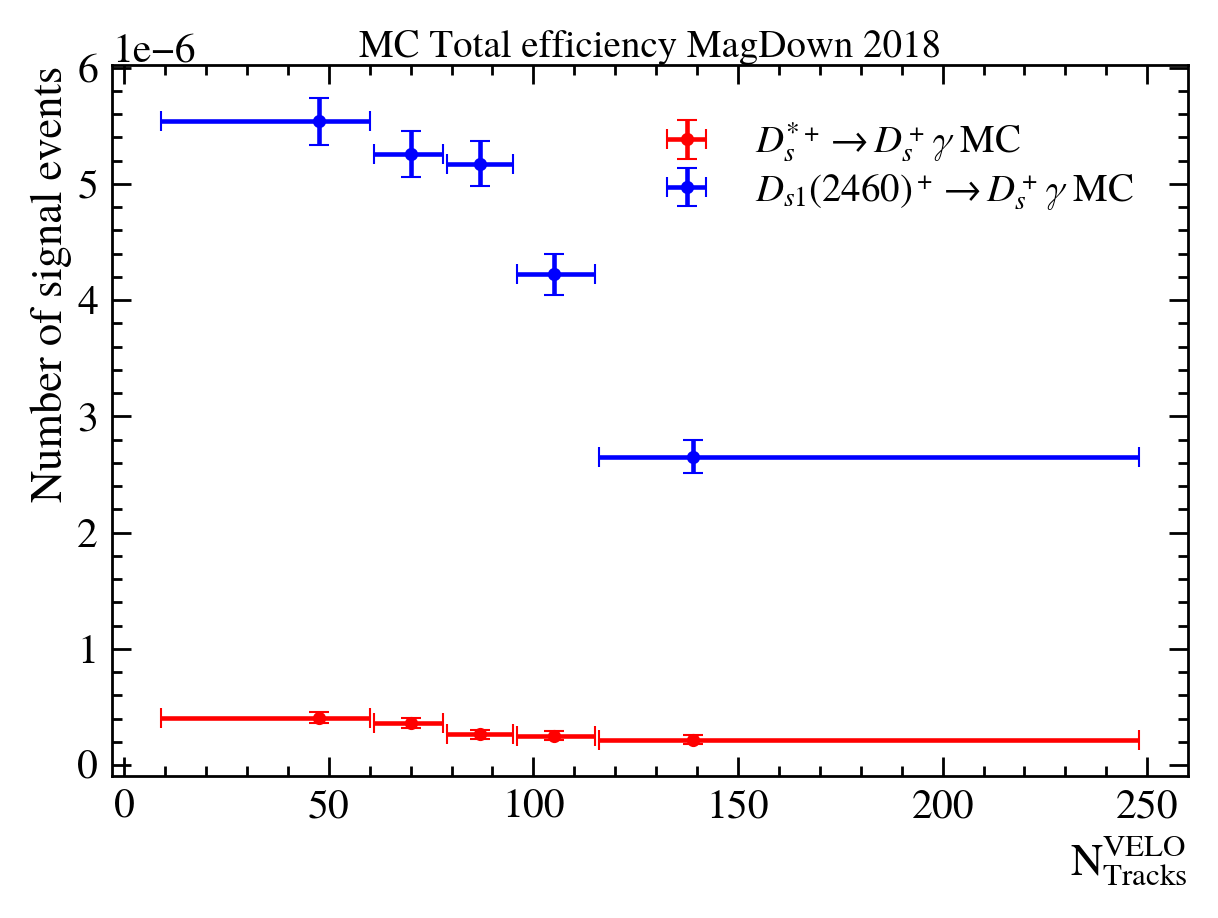

In [10]:
plt.figure(2)
plt.errorbar(nVelo_means, meff_tot_nVelo_Dsst_og, ueff_tot_nVelo_Dsst_og, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.errorbar(nVelo_means, meff_tot_nVelo_Ds1_og, ueff_tot_nVelo_Ds1_og, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Number of signal events")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')

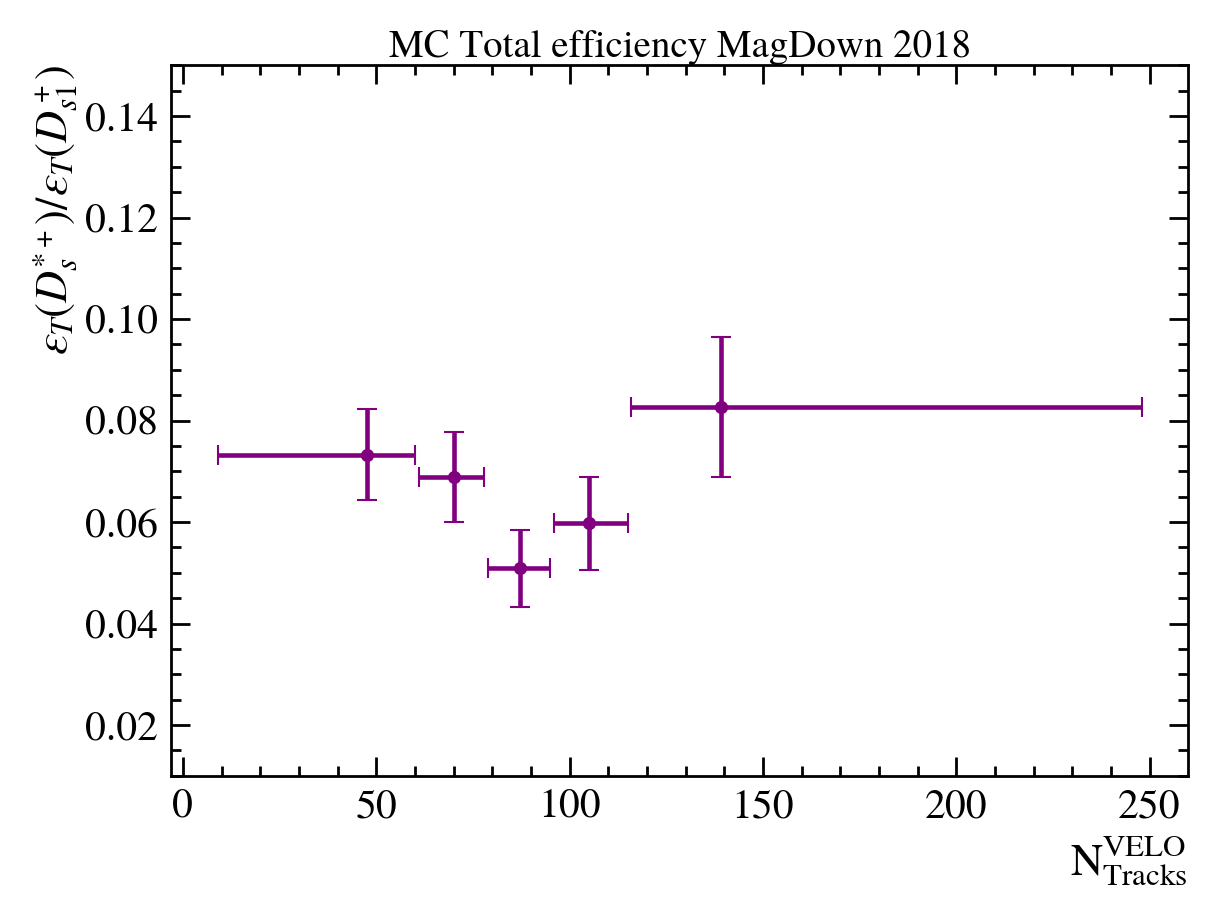

In [11]:
ratio_eff_tot_nVelo_og  = eff_tot_nVelo_Dsst_og / eff_tot_nVelo_Ds1_og

mratio_eff_tot_nVelo_og = np.array([r.nominal_value for r in ratio_eff_tot_nVelo_og])
uratio_eff_tot_nVelo_og = np.array([r.std_dev for r in ratio_eff_tot_nVelo_og])

plt.figure(3)
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_og, uratio_eff_tot_nVelo_og, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="purple", ecolor="purple", capsize=7, label=f"{pol}{year}")
plt.title(f"MC Total efficiency ratio {pol} {year}")
plt.ylim(0.01, 0.15)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{T}(D_s^{*+})/\varepsilon_{T}(D_{s1}^+)$")
plt.title(f"MC Total efficiency {pol} {year}")
plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_ratio_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')

#### V2 strat

In [12]:
## Stripping and reconstruction efficiency
mNbkk_nVelo_Dsst, nVelo_bins = np.histogram(df_Dsst_mc_gen_sig["nVeloTracks"], bins=nVelo_intervals)
mNbkk_nVelo_Ds1, nVelo_bins  = np.histogram(df_Ds1_mc_gen_sig["nVeloTracks"], bins=nVelo_intervals)

uNbkk_nVelo_Dsst = np.sqrt(mNbkk_nVelo_Dsst); uNbkk_nVelo_Ds1 = np.sqrt(mNbkk_nVelo_Ds1)

Nbkk_nVelo_Dsst = np.array([un.ufloat(m, u) for m, u in zip(mNbkk_nVelo_Dsst, uNbkk_nVelo_Dsst)])
Nbkk_nVelo_Ds1  = np.array([un.ufloat(m, u) for m, u in zip(mNbkk_nVelo_Ds1,  uNbkk_nVelo_Ds1)])

mNstrip_nVelo_Dsst, nVelo_bins = np.histogram(df_Dsst_mc_raw_sig["nVeloTracks"], bins=nVelo_intervals)
mNstrip_nVelo_Ds1, nVelo_bins = np.histogram(df_Ds1_mc_raw_sig["nVeloTracks"], bins=nVelo_intervals)

uNstrip_nVelo_Dsst = np.sqrt(mNstrip_nVelo_Dsst); uNstrip_nVelo_Ds1 = np.sqrt(mNstrip_nVelo_Ds1)

Nstrip_nVelo_Dsst = np.array([un.ufloat(m, u) for m, u in zip(mNstrip_nVelo_Dsst, uNstrip_nVelo_Dsst)])
Nstrip_nVelo_Ds1  = np.array([un.ufloat(m, u) for m, u in zip(mNstrip_nVelo_Ds1,  uNstrip_nVelo_Ds1)])

In [13]:
eff_strip_nVelo_Dsst = Nstrip_nVelo_Dsst / Nbkk_nVelo_Dsst
eff_strip_nVelo_Ds1  = Nstrip_nVelo_Ds1 / Nbkk_nVelo_Ds1

meff_strip_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_strip_nVelo_Dsst])
meff_strip_nVelo_Ds1  = np.array([eff.nominal_value for eff in eff_strip_nVelo_Ds1])

ueff_strip_nVelo_Dsst = np.array([eff.std_dev for eff in eff_strip_nVelo_Dsst])
ueff_strip_nVelo_Ds1  = np.array([eff.std_dev for eff in eff_strip_nVelo_Ds1])

ratio_eff_strip_nVelo = eff_strip_nVelo_Dsst / eff_strip_nVelo_Ds1

mratio_eff_strip_nVelo = np.array([r.nominal_value for r in ratio_eff_strip_nVelo])
uratio_eff_strip_nVelo = np.array([r.std_dev for r in ratio_eff_strip_nVelo])

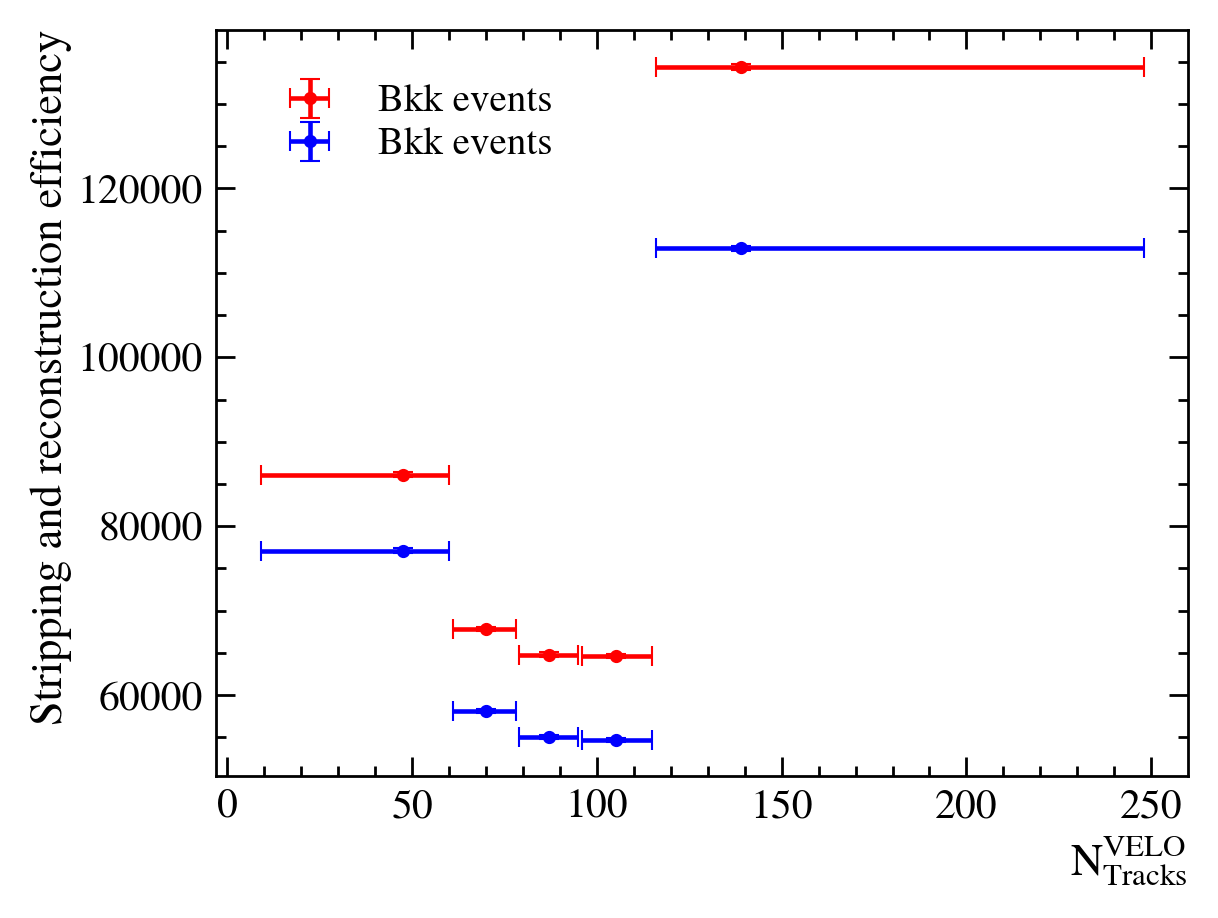

In [40]:
plt.figure(1)
plt.errorbar(nVelo_means, mratio_eff_strip_nVelo, uratio_eff_strip_nVelo, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=f"{pol}{year} MC samples")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Stripping and reconstruction efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
plt.ylim(0.55, 0.7)
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_strip_effs_ratio_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
plt.errorbar(nVelo_means, meff_strip_nVelo_Dsst, ueff_strip_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.errorbar(nVelo_means, meff_strip_nVelo_Ds1, ueff_strip_nVelo_Ds1, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Stripping and reconstruction efficiency")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_strip_effs_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')

plt.figure(3)
plt.subplot(1, 2, 1)
plt.errorbar(nVelo_means, mNbkk_nVelo_Dsst, uNbkk_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Bkk events")
plt.errorbar(nVelo_means, mNstrip_nVelo_Dsst, uNstrip_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="green", ecolor="green", capsize=7, label=r"Stripped events")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Stripping and reconstruction efficiency")
plt.title(r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.legend()
plt.subplot(1, 2, 2)
plt.errorbar(nVelo_means, mNbkk_nVelo_Ds1, uNbkk_nVelo_Ds1, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Bkk events")
plt.errorbar(nVelo_means, mNstrip_nVelo_Ds1, uNstrip_nVelo_Ds1, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="yellow", ecolor="yellow", capsize=7, label=r"Stripped events")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.title(r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.suptitle(f"MC Total efficiency {pol} {year}")
plt.legend()
#plt.savefig(f"./plots/Sim_Both_{pol}{year}_strip_effs_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')++


plt.figure(5)
plt.errorbar(nVelo_means, mNbkk_nVelo_Dsst, uNbkk_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"Bkk events")
plt.errorbar(nVelo_means, mNbkk_nVelo_Ds1, uNbkk_nVelo_Ds1, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"Bkk events")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Stripping and reconstruction efficiency")
#plt.title(r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.legend()


In [15]:
mNoff_nVelo_Dsst, nVelo_bins = np.histogram(df_Dsst_mc_sel_sig["nVeloTracks"], bins=nVelo_intervals)
mNoff_nVelo_Ds1, nVelo_bins  = np.histogram(df_Ds1_mc_sel_sig["nVeloTracks"], bins=nVelo_intervals)

uNoff_nVelo_Dsst = np.sqrt(mNoff_nVelo_Dsst); uNoff_nVelo_Ds1 = np.sqrt(mNoff_nVelo_Ds1)

Noff_nVelo_Dsst = np.array([un.ufloat(m, u) for m, u in zip(mNoff_nVelo_Dsst, uNoff_nVelo_Dsst)])
Noff_nVelo_Ds1  = np.array([un.ufloat(m, u) for m, u in zip(mNoff_nVelo_Ds1,  uNoff_nVelo_Ds1)])

In [16]:
eff_off_nVelo_Dsst = Noff_nVelo_Dsst /  Nstrip_nVelo_Dsst
eff_off_nVelo_Ds1  = Noff_nVelo_Ds1 /  Nstrip_nVelo_Ds1

meff_off_nVelo_Dsst = np.array([eff.nominal_value for eff in eff_off_nVelo_Dsst])
meff_off_nVelo_Ds1  = np.array([eff.nominal_value for eff in eff_off_nVelo_Ds1])

ueff_off_nVelo_Dsst = np.array([eff.std_dev for eff in eff_off_nVelo_Dsst])
ueff_off_nVelo_Ds1  = np.array([eff.std_dev for eff in eff_off_nVelo_Ds1])

ratio_eff_off_nVelo = eff_off_nVelo_Dsst / eff_off_nVelo_Ds1

mratio_eff_off_nVelo = np.array([r.nominal_value for r in ratio_eff_off_nVelo])
uratio_eff_off_nVelo = np.array([r.std_dev for r in ratio_eff_off_nVelo])

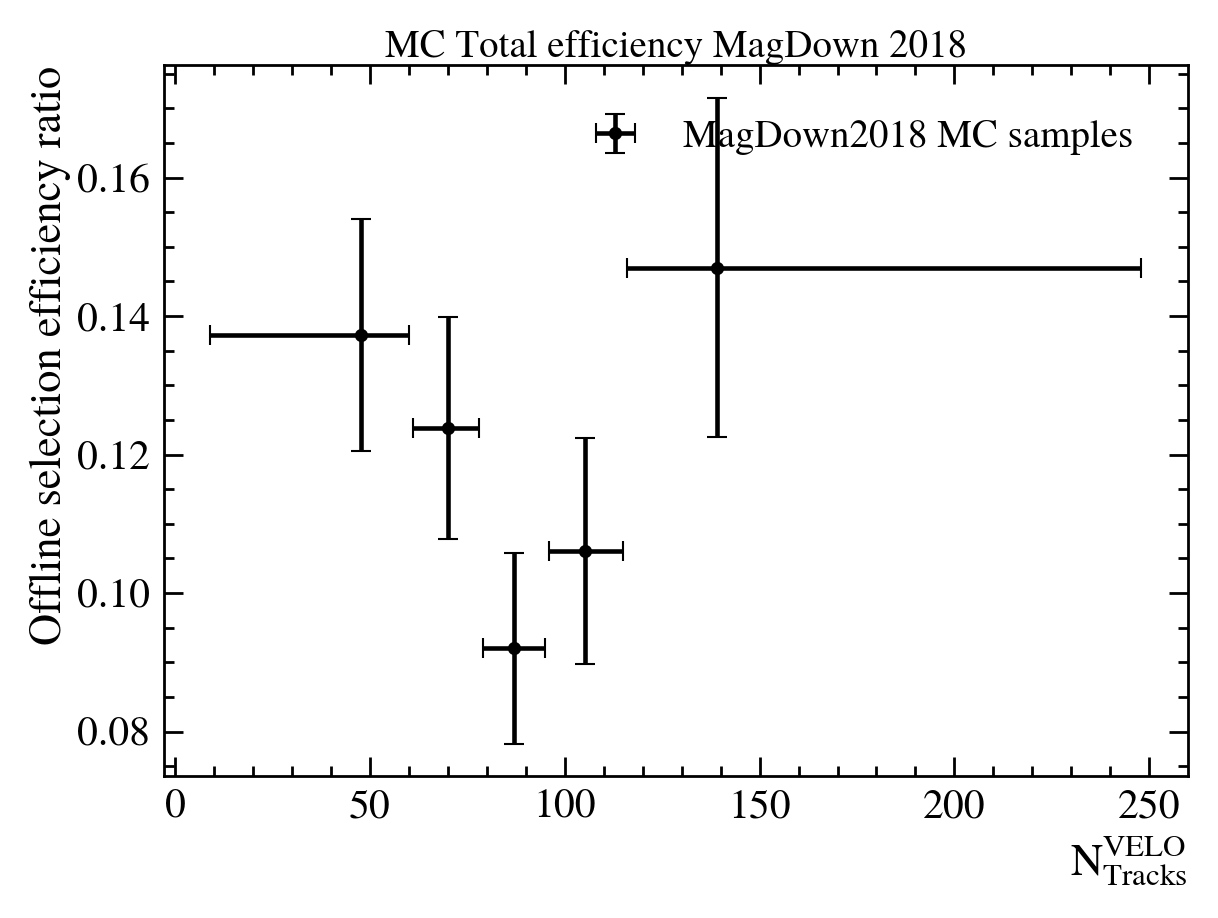

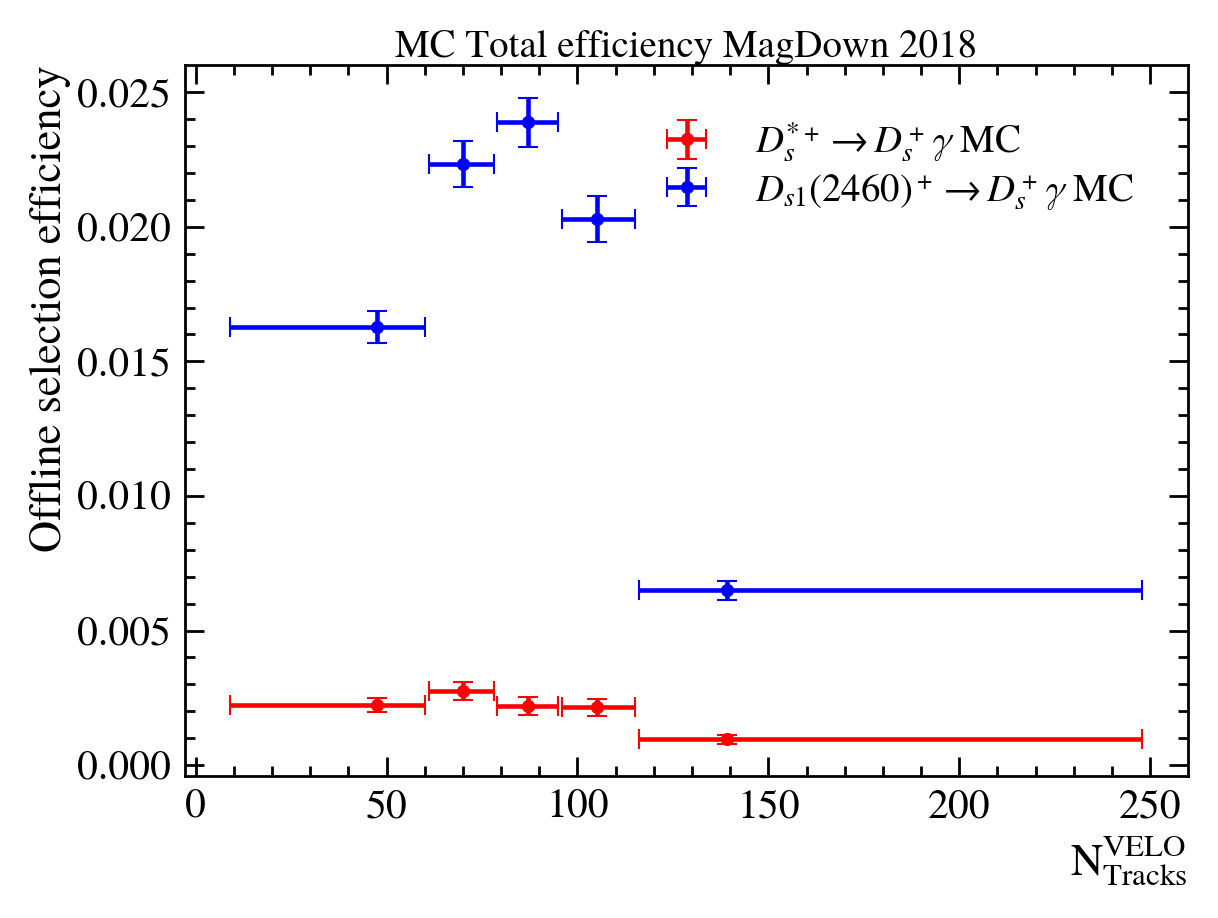

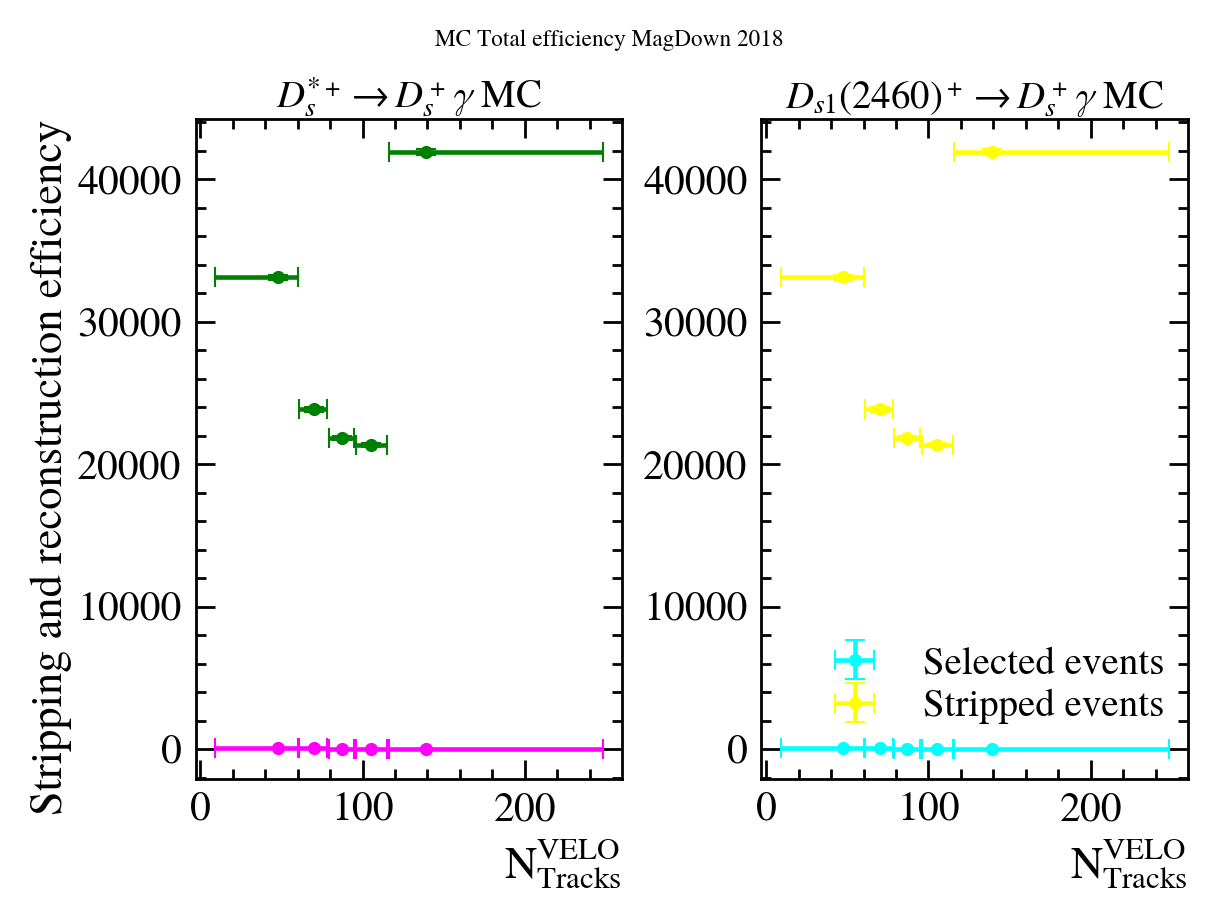

In [17]:
plt.figure(3)
plt.errorbar(nVelo_means, mratio_eff_off_nVelo, uratio_eff_off_nVelo, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=f"{pol}{year} MC samples")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Offline selection efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_off_effs_ratio_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')

plt.figure(4)
plt.errorbar(nVelo_means, meff_off_nVelo_Dsst, ueff_off_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.errorbar(nVelo_means, meff_off_nVelo_Ds1, ueff_off_nVelo_Ds1, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Offline selection efficiency")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_off_effs_{ninters}_nVelo_fst_order.pdf", dpi=300, bbox_inches='tight')

plt.figure(5)
plt.subplot(1, 2, 1)
plt.errorbar(nVelo_means, mNoff_nVelo_Dsst, uNoff_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="magenta", ecolor="magenta", capsize=7, label=r"Selected events")
plt.errorbar(nVelo_means, mNstrip_nVelo_Dsst, uNstrip_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="green", ecolor="green", capsize=7, label=r"Stripped events")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Stripping and reconstruction efficiency")
plt.title(r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.subplot(1, 2, 2)
plt.errorbar(nVelo_means, mNoff_nVelo_Dsst, uNoff_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="cyan", ecolor="cyan", capsize=7, label=r"Selected events")
plt.errorbar(nVelo_means, mNstrip_nVelo_Dsst, uNstrip_nVelo_Dsst, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="yellow", ecolor="yellow", capsize=7, label=r"Stripped events")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.title(r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.suptitle(f"MC Total efficiency {pol} {year}")
plt.legend()

In [18]:
eff_tot_nVelo_Dsst_v2 = eff_gen_Dsst * ret_rate_Dsst * eff_strip_nVelo_Dsst * eff_off_nVelo_Dsst
eff_tot_nVelo_Ds1_v2  = eff_gen_Ds1 * ret_rate_Ds1 * eff_strip_nVelo_Ds1 * eff_off_nVelo_Ds1

meff_tot_nVelo_Dsst_v2 = np.array([eff.nominal_value for eff in eff_tot_nVelo_Dsst_v2])
meff_tot_nVelo_Ds1_v2  = np.array([eff.nominal_value for eff in eff_tot_nVelo_Ds1_v2])

ueff_tot_nVelo_Dsst_v2 = np.array([eff.std_dev for eff in eff_tot_nVelo_Dsst_v2])
ueff_tot_nVelo_Ds1_v2  = np.array([eff.std_dev for eff in eff_tot_nVelo_Ds1_v2])

ratio_eff_tot_nVelo_v2 = eff_tot_nVelo_Dsst_v2 / eff_tot_nVelo_Ds1_v2

mratio_eff_tot_nVelo_v2 = np.array([r.nominal_value for r in ratio_eff_tot_nVelo_v2])
uratio_eff_tot_nVelo_v2 = np.array([r.std_dev for r in ratio_eff_tot_nVelo_v2])

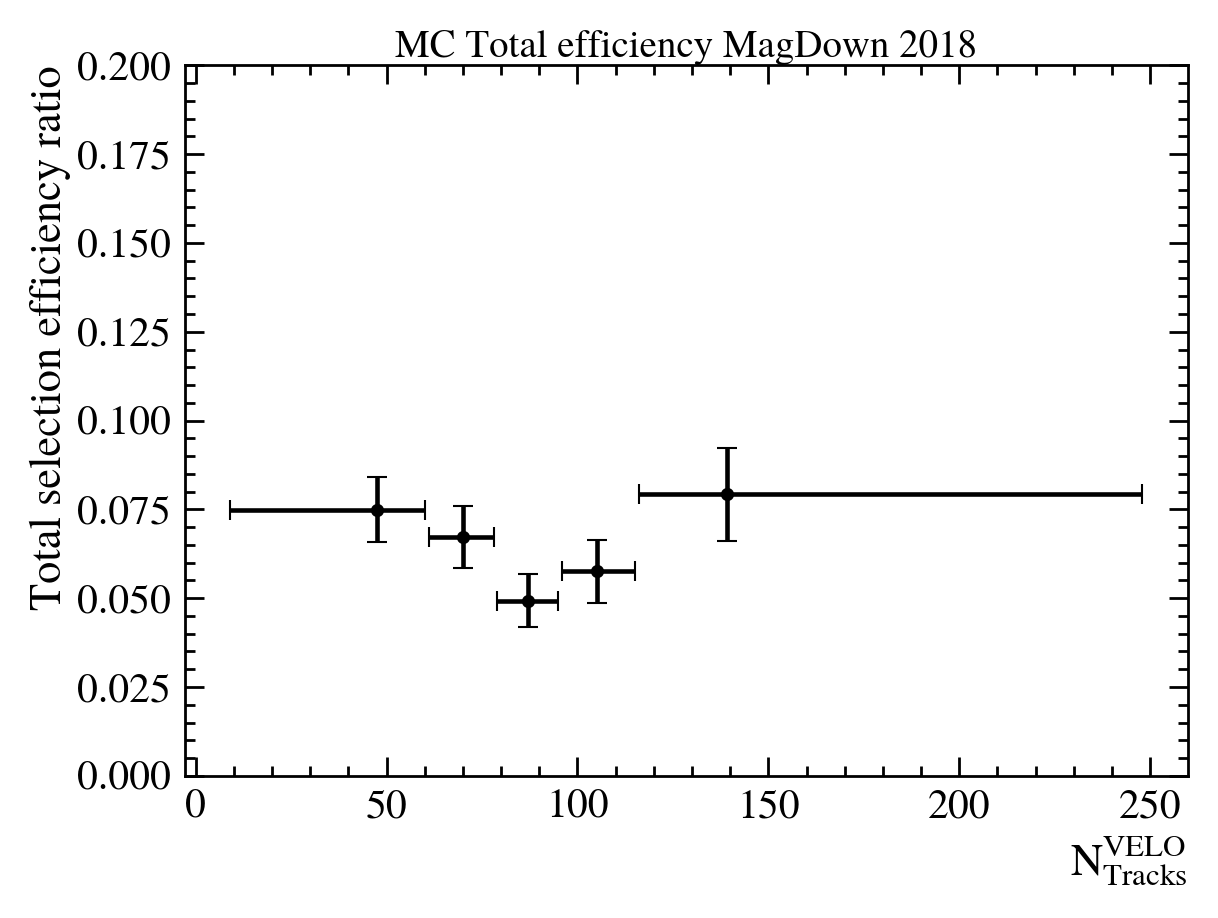

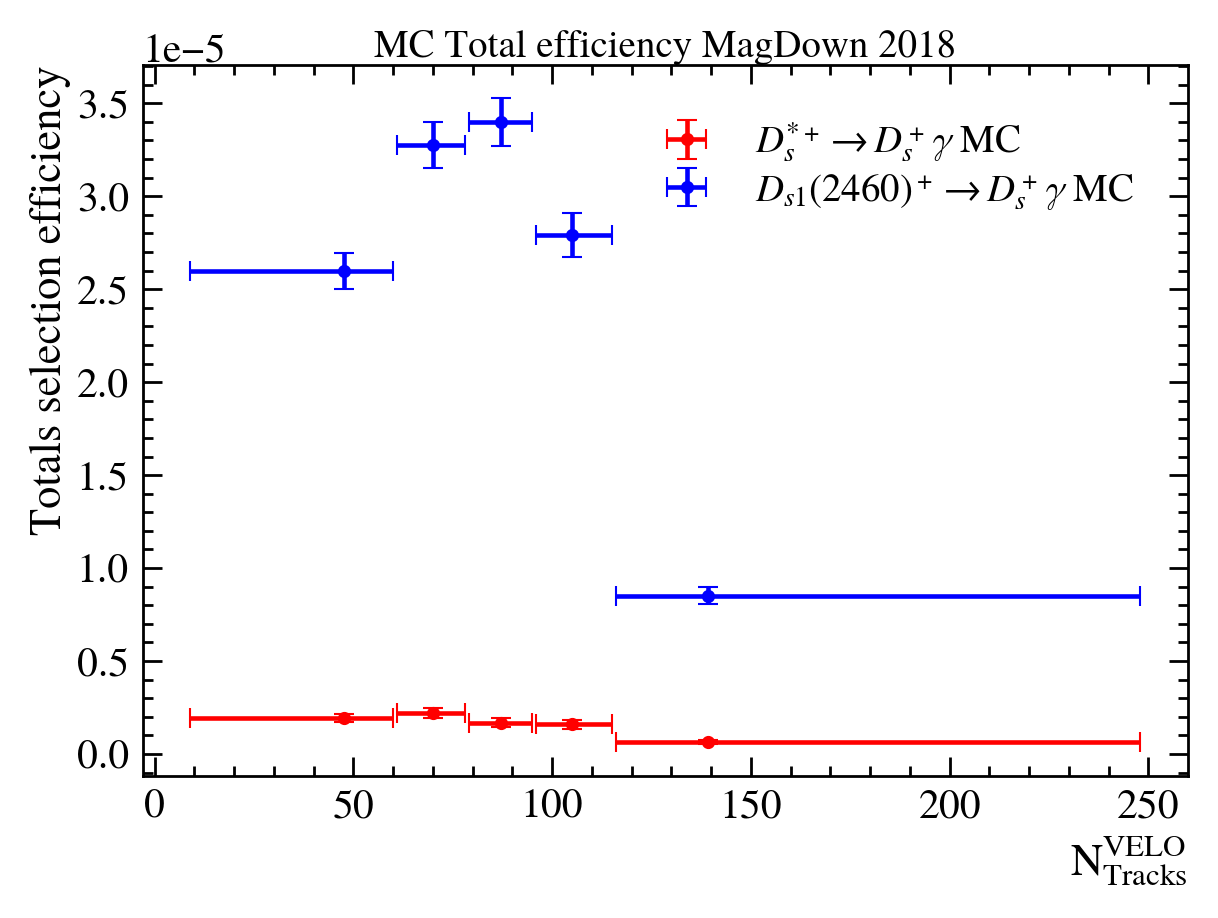

In [38]:
plt.figure(5)
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_v2, uratio_eff_tot_nVelo_v2, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=f"{pol}{year} MC samples")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Total selection efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
plt.ylim(0, 0.2)
plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

plt.figure(6)
plt.errorbar(nVelo_means, meff_tot_nVelo_Dsst_v2, ueff_tot_nVelo_Dsst_v2, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.errorbar(nVelo_means, meff_tot_nVelo_Ds1_v2, ueff_tot_nVelo_Ds1_v2, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Totals selection efficiency")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

#### Strategies comparison

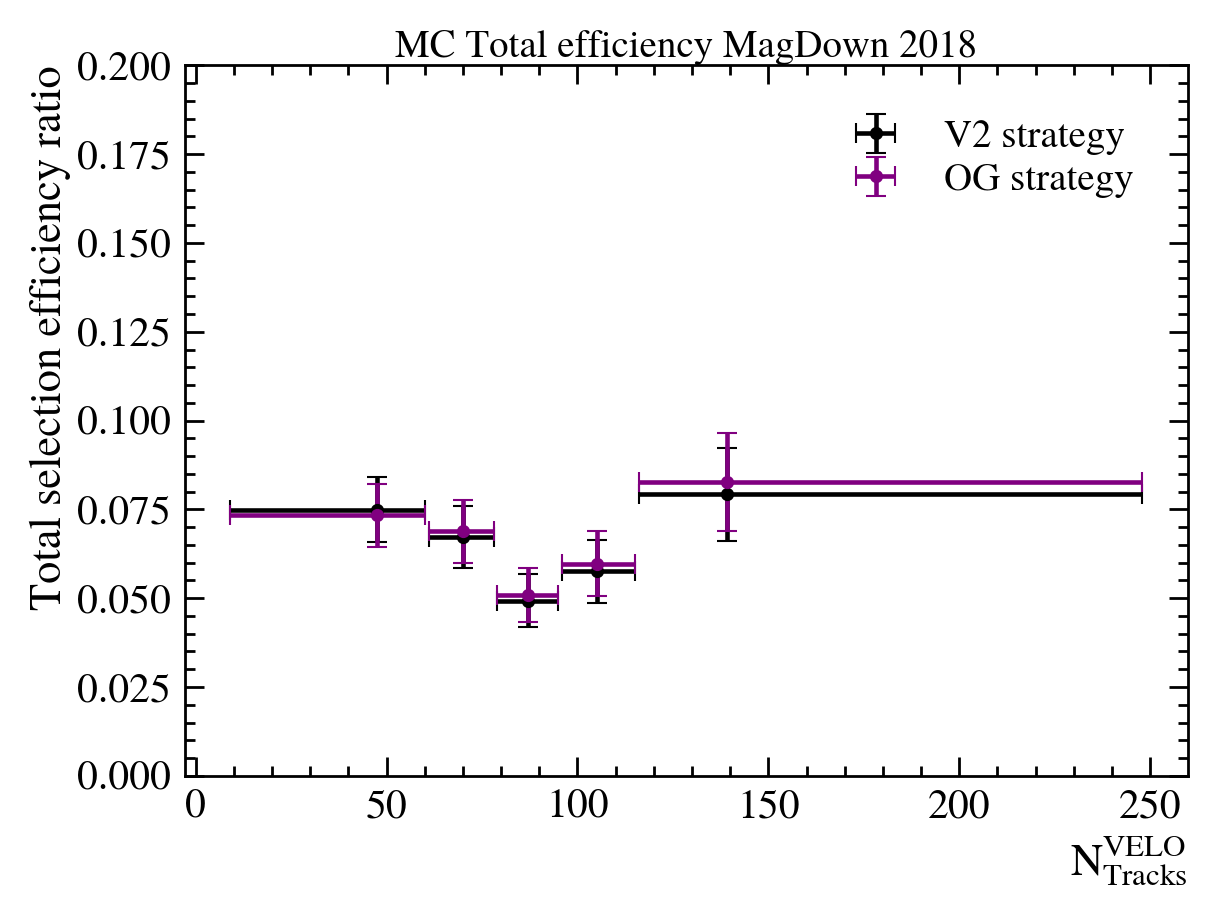

In [31]:
plt.figure(5)
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_v2, uratio_eff_tot_nVelo_v2, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label="V2 strategy")
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_og, uratio_eff_tot_nVelo_og, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="purple", ecolor="purple", capsize=7, label="OG strategy")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Total selection efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
plt.ylim(0, 0.2)
plt.legend()
plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_strat_comp_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

In [34]:
ratio_bkk_nVelo = Nbkk_nVelo_Ds1 / Nbkk_nVelo_Dsst

mratio_bkk_nVelo = np.array([r.nominal_value for r in ratio_bkk_nVelo])
uratio_bkk_nVelo = np.array([r.std_dev for r in ratio_bkk_nVelo])

ratio_Nf_nVelo = Nf_nVelo_Dsst / Nf_nVelo_Ds1

mratio_Nf_nVelo = np.array([r.nominal_value for r in ratio_Nf_nVelo])
uratio_Nf_nVelo = np.array([r.std_dev for r in ratio_Nf_nVelo])

ratio_Nf_Nbkk_prod_nVelo = ratio_Nf_nVelo * ratio_bkk_nVelo
mratio_Nf_Nbkk_prod_nVelo = np.array([r.nominal_value for r in ratio_Nf_Nbkk_prod_nVelo])
uratio_Nf_Nbkk_prod_nVelo = np.array([r.std_dev for r in ratio_Nf_Nbkk_prod_nVelo])

Text(0.5, 1.0, 'Quick cross check')

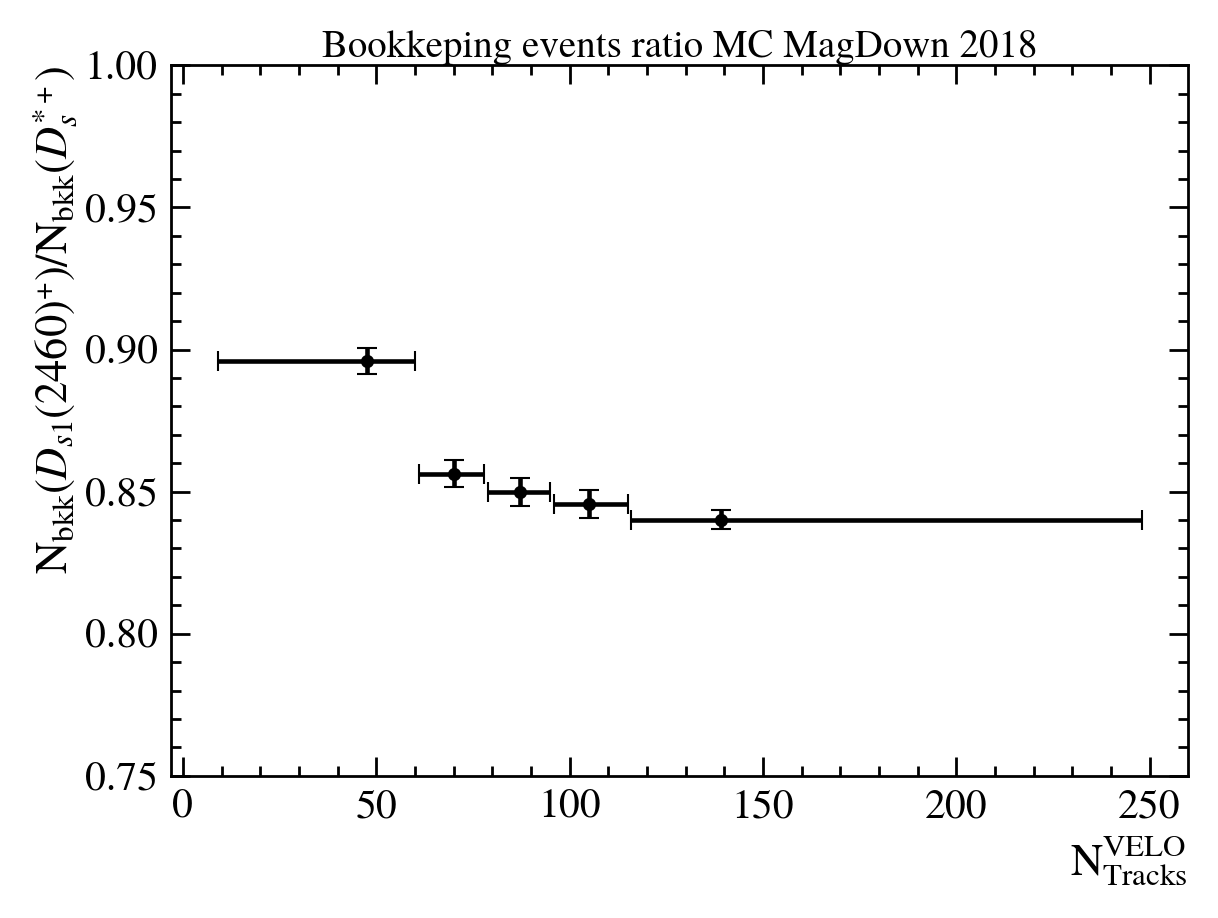

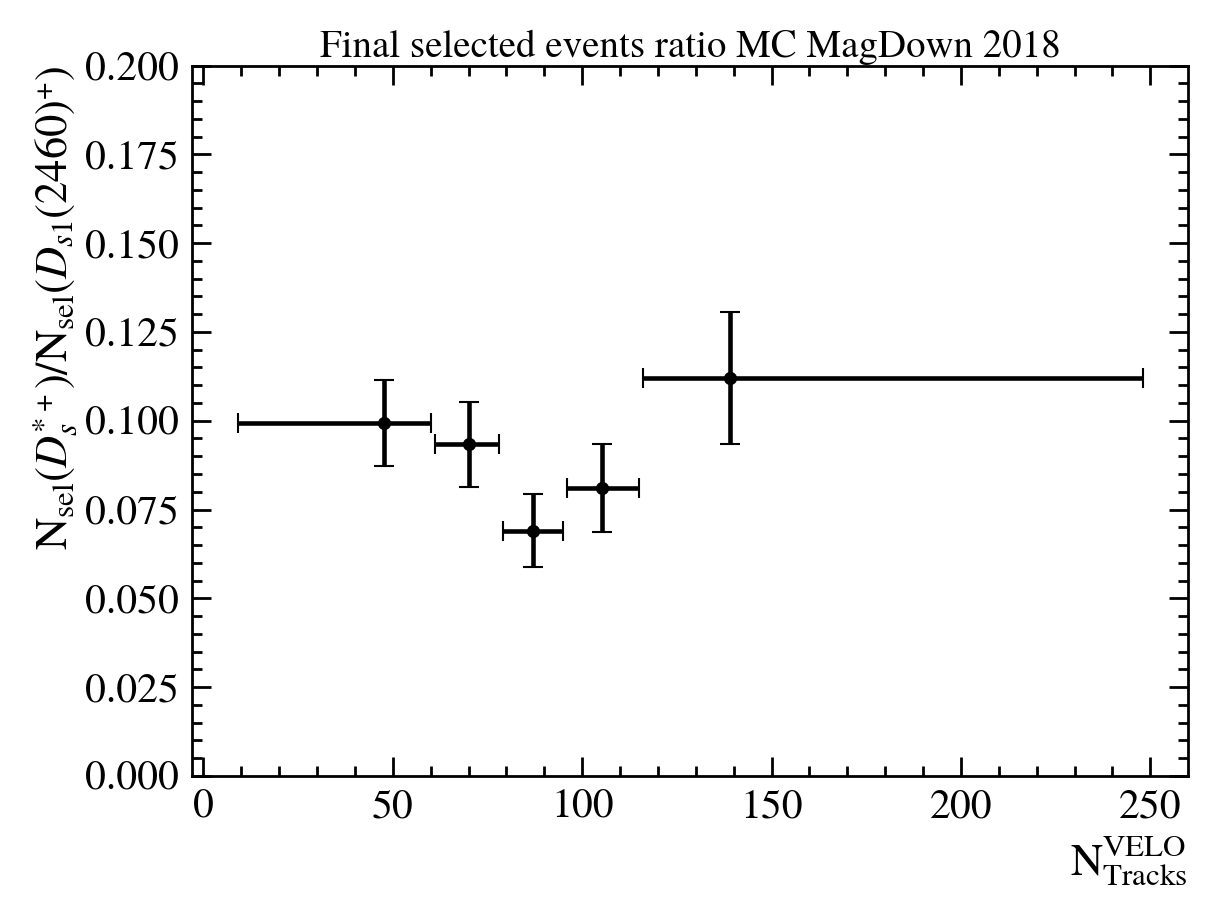

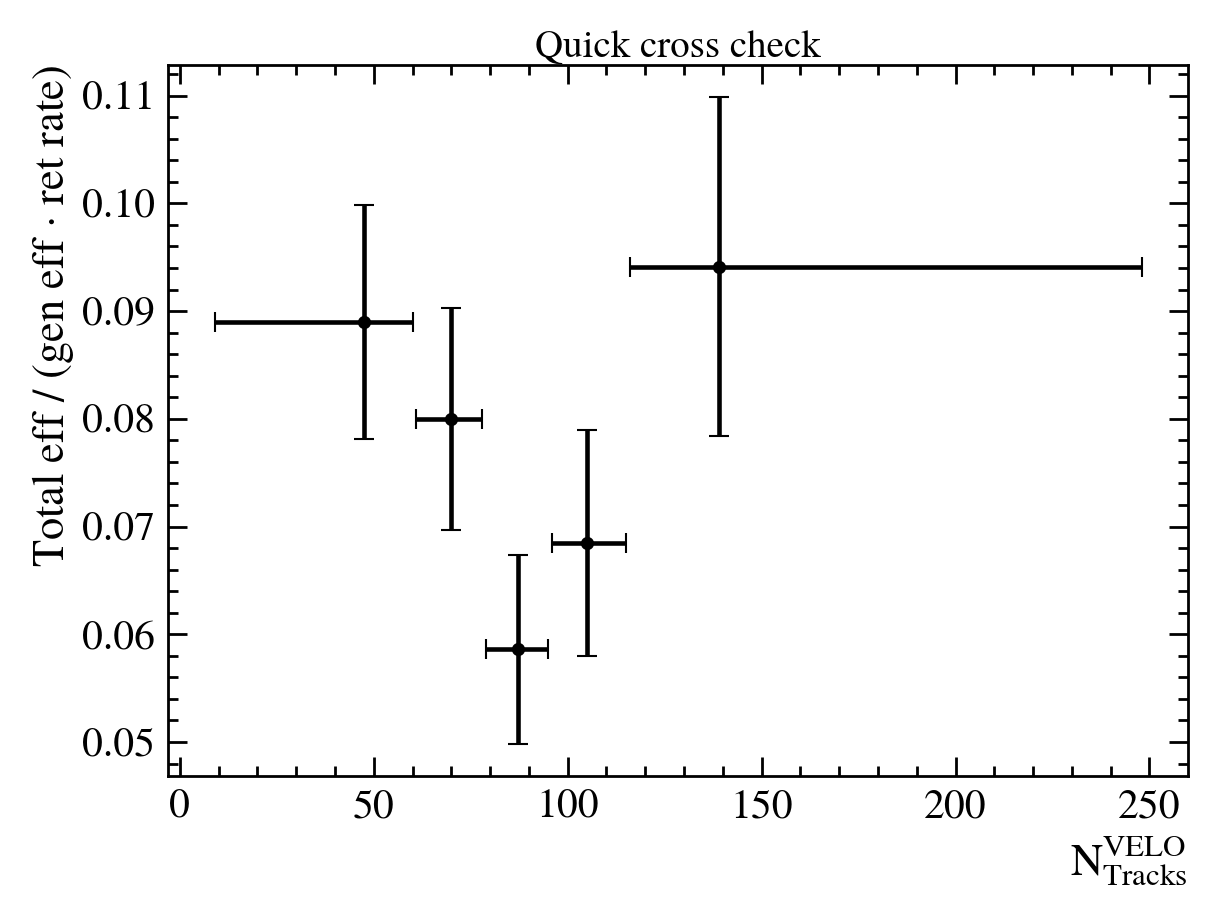

In [37]:
plt.figure(6)
plt.errorbar(nVelo_means, mratio_bkk_nVelo, uratio_bkk_nVelo, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\mathrm{N_{bkk}}(D_{s1}(2460)^{+})/\mathrm{N_{bkk}}(D_s^{*+})$")
plt.title(f"Bookkeping events ratio MC {pol} {year}")
plt.ylim(0.75, 1.0)
plt.savefig(f"./plots/Sim_Both_{pol}{year}_bkk_events_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

plt.figure(7)
plt.errorbar(nVelo_means, mratio_Nf_nVelo, uratio_Nf_nVelo, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\mathrm{N_{sel}}(D_s^{*+})/\mathrm{N_{sel}}(D_{s1}(2460)^{+})$")
plt.title(f"Final selected events ratio MC {pol} {year}")
plt.ylim(0, 0.2)
plt.savefig(f"./plots/Sim_Both_{pol}{year}_final_events_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

plt.figure(8)
plt.errorbar(nVelo_means, mratio_Nf_Nbkk_prod_nVelo, uratio_Nf_Nbkk_prod_nVelo, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7)
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"Total eff / (gen eff $\cdot$ ret rate)")
plt.title(f"Quick cross check")


### nPVs check

In [23]:
tdf_Dsst_mc_gen_sig_pv = tdf_Dsst_mc_gen_sig.Filter("nPVs == 1")
tdf_Ds1_mc_gen_sig_pv  = tdf_Ds1_mc_gen_sig.Filter("nPVs == 1")

df_Dsst_mc_gen_sig_pv = rsh.rdf_to_pdf(tdf_Dsst_mc_gen_sig_pv, columns=["nVeloTracks"])
df_Ds1_mc_gen_sig_pv  = rsh.rdf_to_pdf(tdf_Ds1_mc_gen_sig_pv, columns=["nVeloTracks"])

In [24]:
## Stripping and reconstruction efficiency
mNbkk_nVelo_Dsst_pv, nVelo_bins = np.histogram(df_Dsst_mc_gen_sig_pv["nVeloTracks"], bins=nVelo_intervals)
mNbkk_nVelo_Ds1_pv, nVelo_bins  = np.histogram(df_Ds1_mc_gen_sig_pv["nVeloTracks"], bins=nVelo_intervals)

uNbkk_nVelo_Dsst_pv = np.sqrt(mNbkk_nVelo_Dsst_pv); uNbkk_nVelo_Ds1_pv = np.sqrt(mNbkk_nVelo_Ds1_pv)

Nbkk_nVelo_Dsst_pv = np.array([un.ufloat(m, u) for m, u in zip(mNbkk_nVelo_Dsst_pv, uNbkk_nVelo_Dsst_pv)])
Nbkk_nVelo_Ds1_pv  = np.array([un.ufloat(m, u) for m, u in zip(mNbkk_nVelo_Ds1_pv,  uNbkk_nVelo_Ds1_pv)])

eff_full_sel_nVelo_Dsst_v2_pv = Nf_nVelo_Dsst / Nbkk_nVelo_Dsst_pv
eff_full_sel_nVelo_Ds1_v2_pv  = Nf_nVelo_Ds1 / Nbkk_nVelo_Ds1_pv

meff_full_sel_nVelo_Dsst_v2_pv = np.array([eff.nominal_value for eff in eff_full_sel_nVelo_Dsst_v2_pv])
meff_full_sel_nVelo_Ds1_v2_pv  = np.array([eff.nominal_value for eff in eff_full_sel_nVelo_Ds1_v2_pv])

ueff_full_sel_nVelo_Dsst_v2_pv = np.array([eff.std_dev for eff in eff_full_sel_nVelo_Dsst_v2_pv])
ueff_full_sel_nVelo_Ds1_v2_pv  = np.array([eff.std_dev for eff in eff_full_sel_nVelo_Ds1_v2_pv])

ratio_eff_full_sel_nVelo_v2_pv = eff_full_sel_nVelo_Dsst_v2_pv / eff_full_sel_nVelo_Ds1_v2_pv

mratio_eff_full_sel_nVelo_v2_pv = np.array([r.nominal_value for r in ratio_eff_full_sel_nVelo_v2_pv])
uratio_eff_full_sel_nVelo_v2_pv = np.array([r.std_dev for r in ratio_eff_full_sel_nVelo_v2_pv])

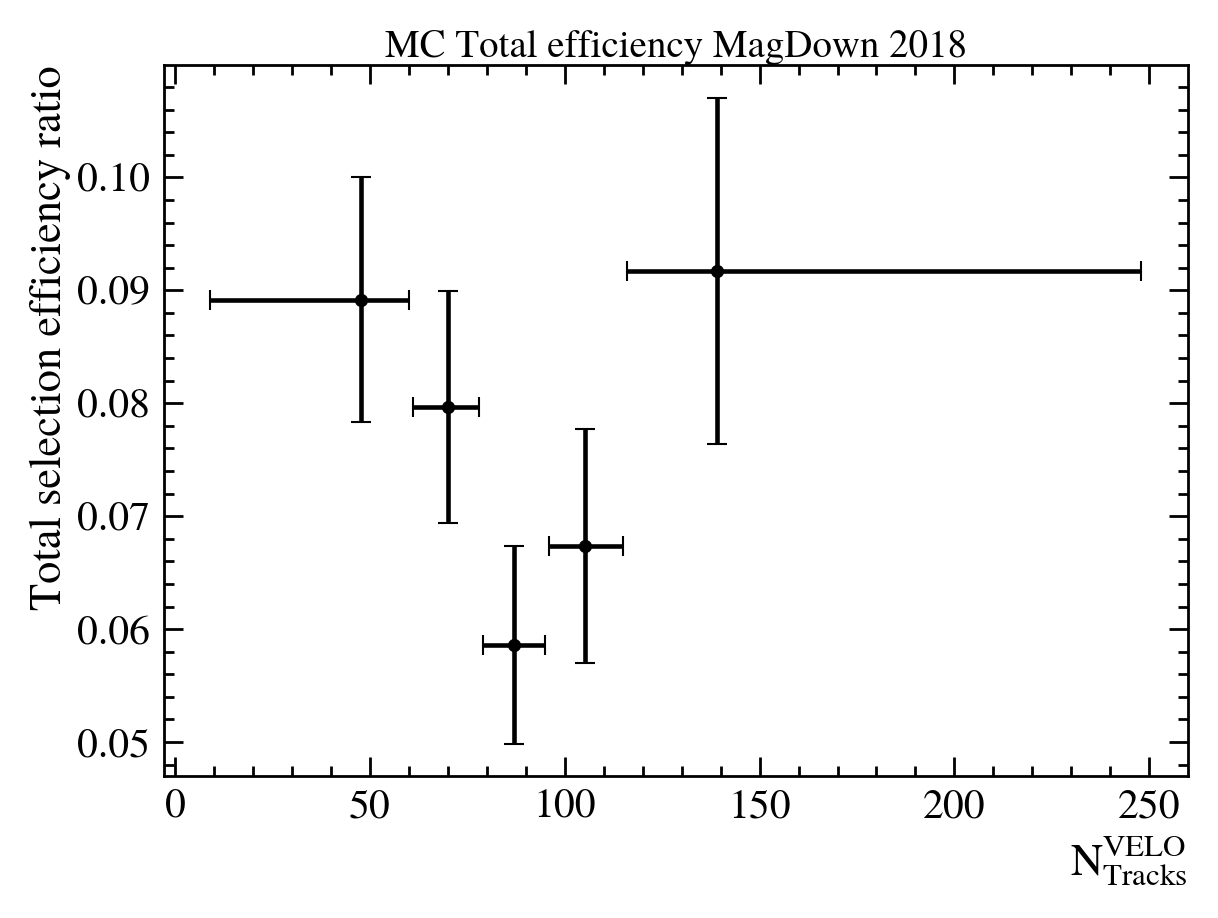

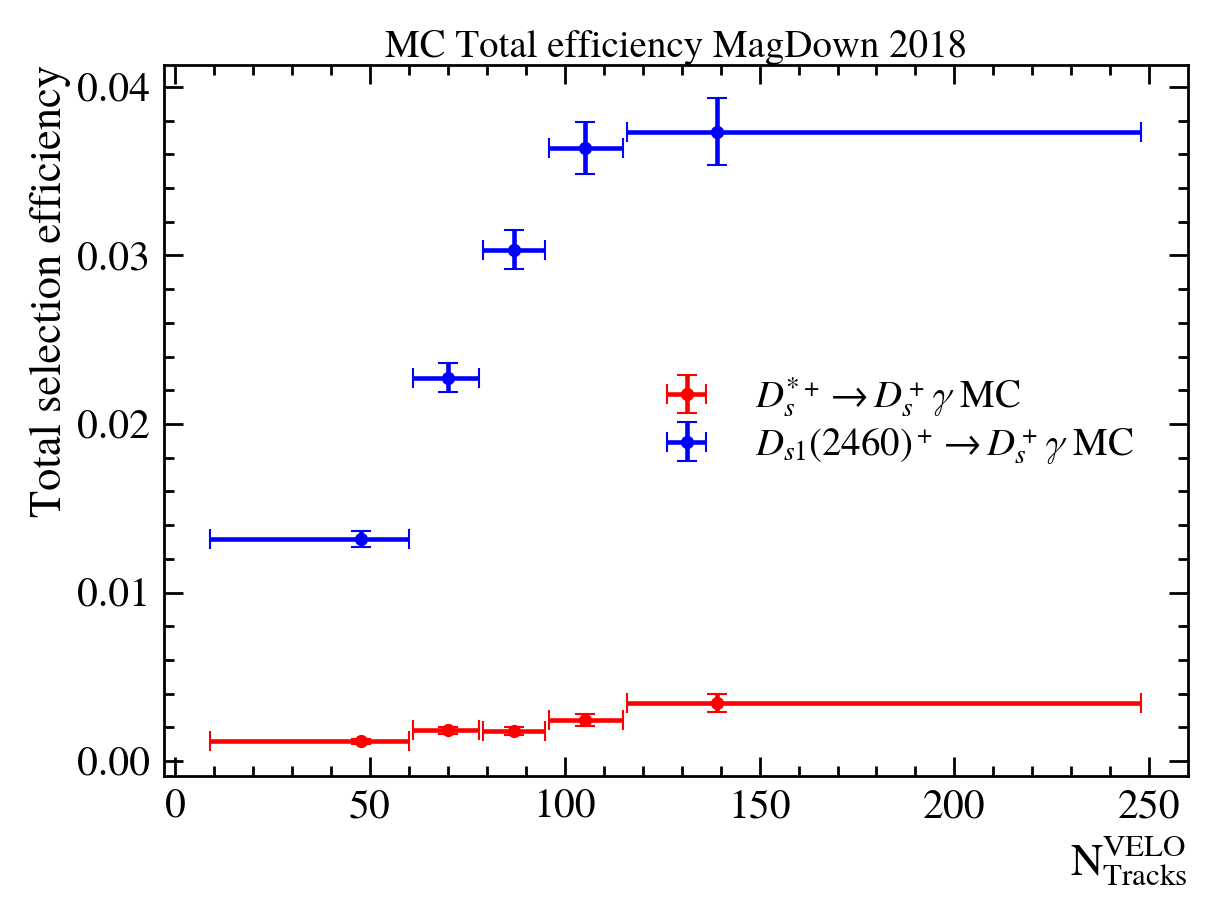

In [ ]:
plt.figure(5)
plt.errorbar(nVelo_means, mratio_eff_full_sel_nVelo_v2_pv, uratio_eff_full_sel_nVelo_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=f"{pol}{year} MC samples")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Total selection efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
plt.ylim(0, 0.)
#plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

plt.figure(6)
plt.errorbar(nVelo_means, meff_full_sel_nVelo_Dsst_v2_pv, ueff_full_sel_nVelo_Dsst_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.errorbar(nVelo_means, meff_full_sel_nVelo_Ds1_v2_pv, ueff_full_sel_nVelo_Ds1_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Total selection efficiency")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()

In [26]:
eff_tot_nVelo_Dsst_v2_pv = eff_gen_Dsst * ret_rate_Dsst * eff_full_sel_nVelo_Dsst_v2_pv
eff_tot_nVelo_Ds1_v2_pv  = eff_gen_Ds1 * ret_rate_Ds1 * eff_full_sel_nVelo_Ds1_v2_pv

meff_tot_nVelo_Dsst_v2_pv = np.array([eff.nominal_value for eff in eff_tot_nVelo_Dsst_v2_pv])
meff_tot_nVelo_Ds1_v2_pv  = np.array([eff.nominal_value for eff in eff_tot_nVelo_Ds1_v2_pv])

ueff_tot_nVelo_Dsst_v2_pv = np.array([eff.std_dev for eff in eff_tot_nVelo_Dsst_v2_pv])
ueff_tot_nVelo_Ds1_v2_pv  = np.array([eff.std_dev for eff in eff_tot_nVelo_Ds1_v2_pv])

ratio_eff_tot_nVelo_v2_pv = eff_tot_nVelo_Dsst_v2_pv / eff_tot_nVelo_Ds1_v2_pv

mratio_eff_tot_nVelo_v2_pv = np.array([r.nominal_value for r in ratio_eff_tot_nVelo_v2_pv])
uratio_eff_tot_nVelo_v2_pv = np.array([r.std_dev for r in ratio_eff_tot_nVelo_v2_pv])

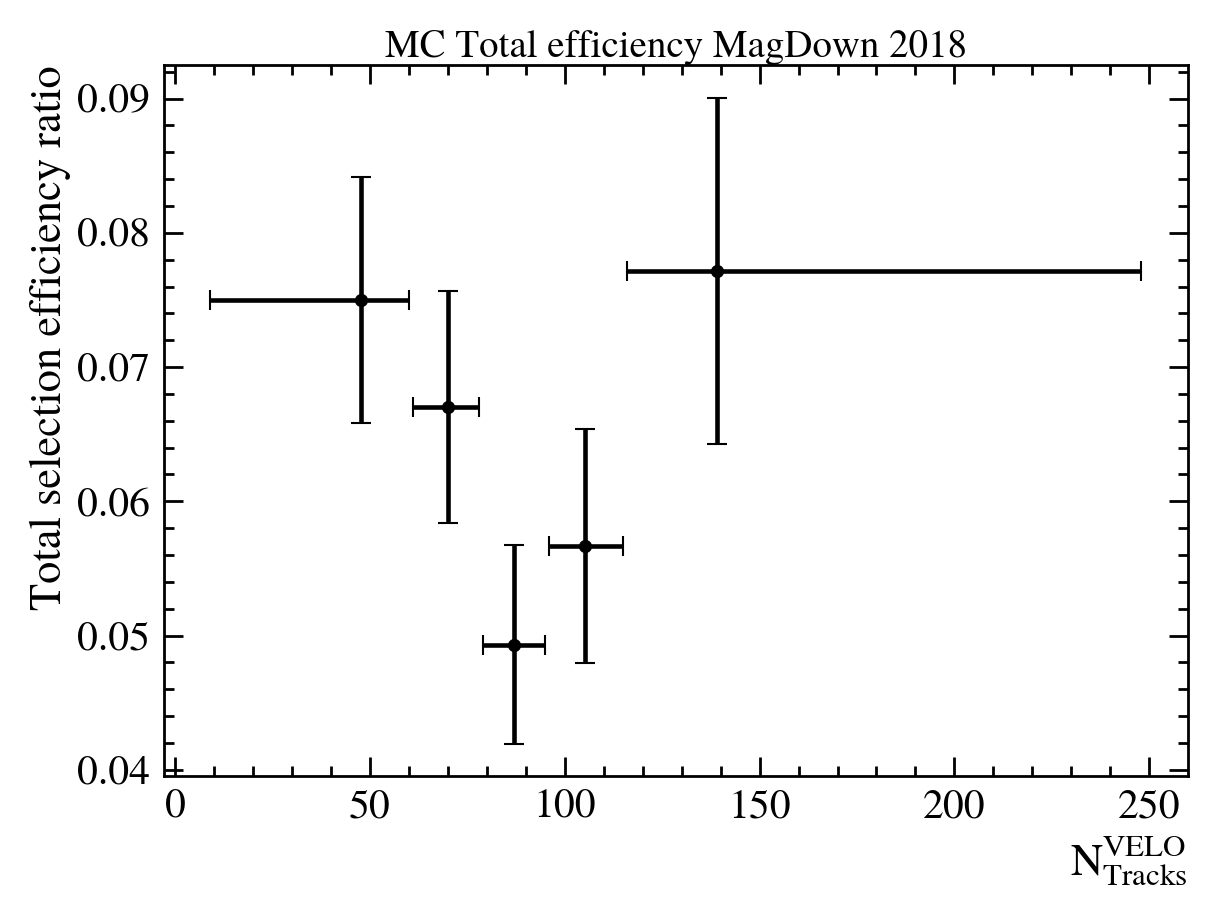

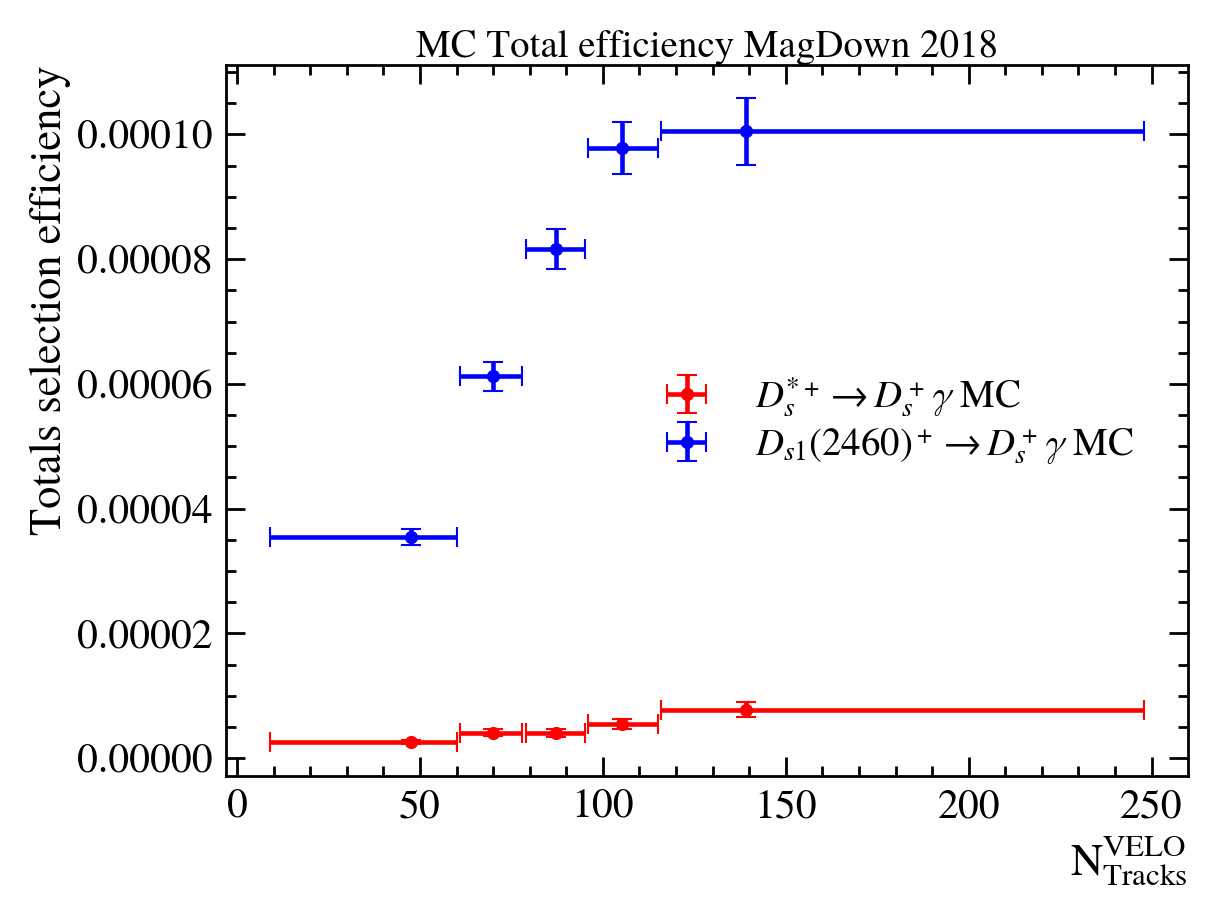

In [27]:
plt.figure(5)
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_v2_pv, uratio_eff_tot_nVelo_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label=f"{pol}{year} MC samples")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Total selection efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
#plt.ylim(0.01, 0.15)
#plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

plt.figure(6)
plt.errorbar(nVelo_means, meff_tot_nVelo_Dsst_v2_pv, ueff_tot_nVelo_Dsst_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="red", ecolor="red", capsize=7, label=r"$D_s^{*+} \to D_s^+ \gamma$ MC")
plt.errorbar(nVelo_means, meff_tot_nVelo_Ds1_v2_pv, ueff_tot_nVelo_Ds1_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="blue", ecolor="blue", capsize=7, label=r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ MC")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Totals selection efficiency")
plt.title(f"MC Total efficiency {pol} {year}")
plt.legend()
#plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')

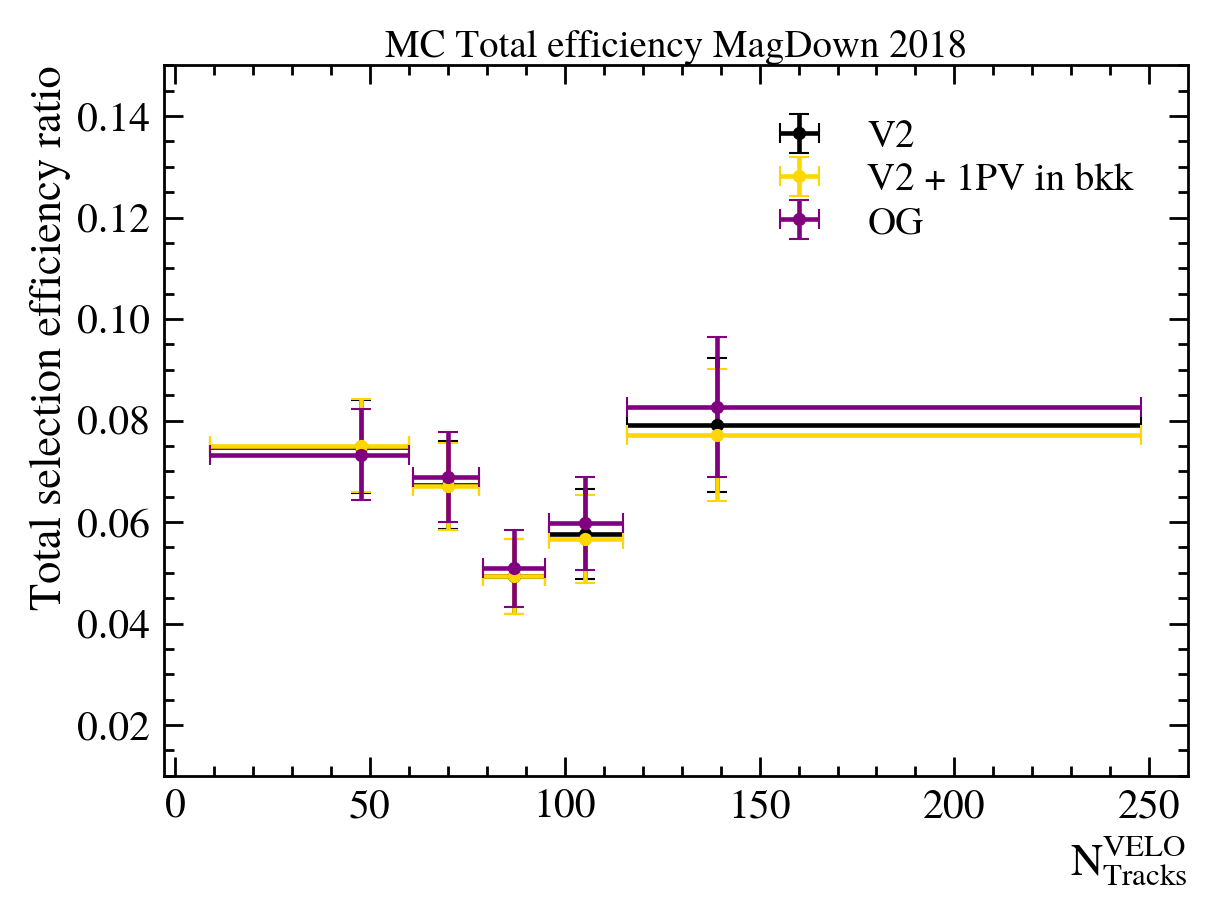

In [28]:
plt.figure(5)
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_v2, uratio_eff_tot_nVelo_v2, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="black", ecolor="black", capsize=7, label="V2")
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_v2_pv, uratio_eff_tot_nVelo_v2_pv, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="gold", ecolor="gold", capsize=7, label="V2 + 1PV in bkk")
plt.errorbar(nVelo_means, mratio_eff_tot_nVelo_og, uratio_eff_tot_nVelo_og, xerr=[nVelo_down, nVelo_up], 
             fmt='.', color="purple", ecolor="purple", capsize=7, label="OG")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("Total selection efficiency ratio")
plt.title(f"MC Total efficiency {pol} {year}")
plt.ylim(0.01, 0.15)
plt.legend()
#plt.savefig(f"./plots/Sim_Both_{pol}{year}_tot_effs_ratio_{ninters}_nVelo_fst_order_v2.pdf", dpi=300, bbox_inches='tight')